<a href="https://colab.research.google.com/github/jugalpanchal/bd-chef/blob/main/spark_etl_crime_anlys_recipe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Spark Session

In [ ]:
# Follow the steps to install the dependencies:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null # install java
!wget -q https://downloads.apache.org/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz # spark package download
!tar xf spark-3.1.2-bin-hadoop3.2.tgz # unzip spark package
!pip install -q findspark # install spark

# Set the location of Java and Spark:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop3.2"

import findspark
findspark.init()

In [ ]:
from pyspark.sql import SparkSession

# create or get spark session
spark = SparkSession.builder \
        .master("local[*]") \
        .appName("Spark_App1") \
        .getOrCreate()

sc = spark.sparkContext

### Read a file

In [ ]:
data = spark.read\
            .format("csv")\
            .option("header", "true")\
            .load("datasets/london_crime_by_lsoa.csv")

data.count() #DataFrame count

999

In [ ]:
# easy alternative
#data = spark.read.csv('datasets/london_crime_by_lsoa.csv', inferSchema=True, header=True)
data.printSchema()
data.show()

root
 |-- lsoa_code: string (nullable = true)
 |-- borough: string (nullable = true)
 |-- major_category: string (nullable = true)
 |-- minor_category: string (nullable = true)
 |-- value: string (nullable = true)
 |-- year: string (nullable = true)
 |-- month: string (nullable = true)

+---------+--------------------+--------------------+--------------------+-----+----+-----+
|lsoa_code|             borough|      major_category|      minor_category|value|year|month|
+---------+--------------------+--------------------+--------------------+-----+----+-----+
|E01001116|             Croydon|            Burglary|Burglary in Other...|    0|2016|   11|
|E01001646|           Greenwich|Violence Against ...|      Other violence|    0|2016|   11|
|E01000677|             Bromley|Violence Against ...|      Other violence|    0|2015|    5|
|E01003774|           Redbridge|            Burglary|Burglary in Other...|    0|2016|    3|
|E01004563|          Wandsworth|             Robbery|   Personal Pro

### NA, Drop Column, Select, Distinct, Filter(==, isin, >=), Sample-Fraction 

In [ ]:
data = data.dropna() # Drop NA values records(Rows)
data.count()

999

In [ ]:
data.drop("lsoa_code")
total_borough = data.select("borough").distinct()

total_borough.show()

+--------------------+
|             borough|
+--------------------+
|             Croydon|
|          Wandsworth|
|              Bexley|
|             Lambeth|
|Barking and Dagenham|
|              Camden|
|           Greenwich|
|              Newham|
|       Tower Hamlets|
|            Hounslow|
|              Barnet|
|              Harrow|
|Kensington and Ch...|
|           Islington|
|               Brent|
|            Haringey|
|             Bromley|
|              Merton|
|         Westminster|
|             Hackney|
+--------------------+
only showing top 20 rows



In [ ]:
hackney_data = data.filter(data['borough'] == 'Hackney')
hackney_data.show(5) # any 5

+---------+-------+--------------------+--------------------+-----+----+-----+
|lsoa_code|borough|      major_category|      minor_category|value|year|month|
+---------+-------+--------------------+--------------------+-----+----+-----+
|E01001786|Hackney|     Criminal Damage|Criminal Damage T...|    0|2011|    6|
|E01001794|Hackney|Violence Against ...|          Harassment|    1|2013|    2|
|E01001787|Hackney|     Criminal Damage|Other Criminal Da...|    0|2011|    7|
|E01001738|Hackney|Violence Against ...|        Wounding/GBH|    0|2013|   12|
|E01001807|Hackney|  Theft and Handling|  Other Theft Person|    0|2016|    8|
+---------+-------+--------------------+--------------------+-----+----+-----+
only showing top 5 rows



In [ ]:
data_2015_2016 = data.filter(data['year'].isin(['2015', '2016'])) 
data_2015_2016.count() # 2997912
data_2015_2016_fra_per = data_2015_2016.sample(fraction=0.2) # Ex 0.2 means 20% so it creates a new dataframe with 20% data from source
data_2015_2016_fra_per.show()

+---------+--------------------+--------------------+--------------------+-----+----+-----+
|lsoa_code|             borough|      major_category|      minor_category|value|year|month|
+---------+--------------------+--------------------+--------------------+-----+----+-----+
|E01002360|            Havering|    Fraud or Forgery|  Counted per Victim|    0|2015|   11|
|E01004436|      Waltham Forest|Other Notifiable ...|      Going Equipped|    0|2015|    2|
|E01003989|           Southwark|  Theft and Handling|    Theft From Shops|    4|2016|    8|
|E01001600|           Greenwich|            Burglary|Burglary in Other...|    0|2016|   11|
|E01002938|Kingston upon Thames|  Theft and Handling|Motor Vehicle Int...|    0|2016|    5|
|E01003067|             Lambeth|Violence Against ...|    Offensive Weapon|    0|2016|    4|
|E01002641|            Hounslow|Violence Against ...|    Offensive Weapon|    1|2015|   10|
|E01002740|           Islington|     Sexual Offences|        Other Sexual|    0|

In [ ]:
data_data_onwards = data.filter(data['year'] >= 2016)
data_data_onwards.sample(fraction = 0.1).show() #10%

+---------+--------------------+--------------------+--------------------+-----+----+-----+
|lsoa_code|             borough|      major_category|      minor_category|value|year|month|
+---------+--------------------+--------------------+--------------------+-----+----+-----+
|E01001806|             Hackney|             Robbery|   Business Property|    0|2016|    7|
|E01002276|            Havering|            Burglary|Burglary in a Dwe...|    1|2016|    8|
|E01002740|           Islington|     Sexual Offences|        Other Sexual|    0|2016|   10|
|E01002884|Kensington and Ch...|Other Notifiable ...|    Other Notifiable|    0|2016|   10|
|E01002367|            Havering|Other Notifiable ...|    Other Notifiable|    0|2016|    6|
|E01002835|Kensington and Ch...|  Theft and Handling|         Other Theft|    7|2016|    1|
|E01001312|              Ealing|            Burglary|Burglary in Other...|    0|2016|    5|
|E01001100|             Croydon|Violence Against ...|        Wounding/GBH|    0|

### Aggregation - groupBy, agg, orderBy, sort

In [ ]:
borough_and_count = data.groupBy('borough').count()

borough_and_count.show()

+--------------------+-----+
|             borough|count|
+--------------------+-----+
|             Croydon|   45|
|          Wandsworth|   38|
|              Bexley|   27|
|             Lambeth|   46|
|Barking and Dagenham|   30|
|              Camden|   22|
|           Greenwich|   30|
|              Newham|   43|
|       Tower Hamlets|   19|
|            Hounslow|   30|
|              Barnet|   39|
|              Harrow|   19|
|Kensington and Ch...|   20|
|           Islington|   34|
|               Brent|   32|
|            Haringey|   36|
|             Bromley|   42|
|              Merton|   25|
|         Westminster|   35|
|             Hackney|   27|
+--------------------+-----+
only showing top 20 rows



In [ ]:
# the sum is a method and the value is column in the dataframe.
#data = data.sample(fraction = 0.001)

borought_conviction_sum = data.groupBy('borough')\
                              .agg({"value":"sum"})\ # aggregation method
                              .withColumnRenamed("sum(value)", "convictions")

borought_conviction_sum.show()

+--------------------+-----------+
|             borough|convictions|
+--------------------+-----------+
|             Croydon|       28.0|
|          Wandsworth|        9.0|
|              Bexley|        9.0|
|             Lambeth|       28.0|
|Barking and Dagenham|       12.0|
|              Camden|       25.0|
|           Greenwich|       13.0|
|              Newham|       14.0|
|       Tower Hamlets|       11.0|
|            Hounslow|       15.0|
|              Barnet|       13.0|
|              Harrow|       11.0|
|Kensington and Ch...|       16.0|
|           Islington|       24.0|
|               Brent|        8.0|
|            Haringey|       29.0|
|             Bromley|       29.0|
|              Merton|       14.0|
|         Westminster|       46.0|
|             Hackney|        8.0|
+--------------------+-----------+
only showing top 20 rows



In [ ]:
borought_conviction_sum_total = borought_conviction_sum.agg({"convictions":"sum"})
borought_conviction_sum_total.show()
total_convictions = borought_conviction_sum_total.collect()[0][0] # 0 row and 0 column

+----------------+
|sum(convictions)|
+----------------+
|           487.0|
+----------------+



In [ ]:
import pyspark.sql.functions as func
from pyspark.sql.functions import lit # literal

# Somehow it is not working.
borought_conviction_per = borought_conviction_sum.withColumn("contribution percentage(%)", 
                                                             func.round(borought_conviction_sum.convictions / total_convictions * 100, 2)\
                                                             )
borought_conviction_per.show(5)

+--------------------+-----------+--------------------------+
|             borough|convictions|contribution percentage(%)|
+--------------------+-----------+--------------------------+
|             Croydon|       28.0|                      5.75|
|          Wandsworth|        9.0|                      1.85|
|              Bexley|        9.0|                      1.85|
|             Lambeth|       28.0|                      5.75|
|Barking and Dagenham|       12.0|                      2.46|
+--------------------+-----------+--------------------------+
only showing top 5 rows



In [ ]:
# 2 column - contribution percentage(%)
borought_conviction_per.orderBy(borought_conviction_per[2].desc())\
                        .show()

+--------------------+-----------+--------------------------+
|             borough|convictions|contribution percentage(%)|
+--------------------+-----------+--------------------------+
|         Westminster|       46.0|                      9.45|
|            Haringey|       29.0|                      5.95|
|             Bromley|       29.0|                      5.95|
|             Lambeth|       28.0|                      5.75|
|             Croydon|       28.0|                      5.75|
|              Camden|       25.0|                      5.13|
|           Islington|       24.0|                      4.93|
|Hammersmith and F...|       19.0|                       3.9|
|Kensington and Ch...|       16.0|                      3.29|
|      Waltham Forest|       15.0|                      3.08|
|            Hounslow|       15.0|                      3.08|
|           Southwark|       15.0|                      3.08|
|              Newham|       14.0|                      2.87|
|       

In [ ]:
conviction_monthly = data.filter(data['year'] == 2014)\
                          .groupBy('month')\
                          .agg({"value":"sum"})\
                          .withColumnRenamed("sum(value)", "convictions")

conviction_monthly.show()

+-----+-----------+
|month|convictions|
+-----+-----------+
|    7|        6.0|
|   11|        1.0|
|    3|        0.0|
|    8|        1.0|
|    5|        8.0|
|    6|        1.0|
|    9|        7.0|
|    1|        3.0|
|   10|        0.0|
|    4|        3.0|
|   12|        6.0|
|    2|        5.0|
+-----+-----------+



In [ ]:
conviction_monthly_sort = conviction_monthly.sort(conviction_monthly.convictions.desc())
conviction_monthly_sort.show()

+-----+-----------+
|month|convictions|
+-----+-----------+
|    5|        8.0|
|    9|        7.0|
|   12|        6.0|
|    7|        6.0|
|    2|        5.0|
|    4|        3.0|
|    1|        3.0|
|   11|        1.0|
|    8|        1.0|
|    6|        1.0|
|    3|        0.0|
|   10|        0.0|
+-----+-----------+



### Pivot Column - Convert the column values to column names

In [ ]:
# Two columns - 1st, 2nd - both are in the source dataframe
# New column - value from 1st column, Values from 2nd column, ...

# borough is a district(town).
# These are major_category - 'Burglary', 'Drugs', 'Fraud or Forgery', 'Robbery'
data.crosstab('borough', 'major_category')\
    .select('borough_major_category', 'Burglary', 'Drugs', 'Fraud or Forgery', 'Robbery')\ # borough_major_category is created internally through the crosstab. :)
    .show()

+----------------------+--------+-----+----------------+-------+
|borough_major_category|Burglary|Drugs|Fraud or Forgery|Robbery|
+----------------------+--------+-----+----------------+-------+
|              Havering|       3|    2|               2|      3|
|                Merton|       2|    3|               0|      2|
|              Haringey|       1|    0|               0|      2|
|         Tower Hamlets|       1|    2|               0|      2|
|               Bromley|       1|    2|               2|      4|
|               Enfield|       0|    4|               1|      2|
|  Kingston upon Thames|       0|    1|               1|      1|
|           Westminster|       0|    3|               0|      0|
|  Richmond upon Thames|       3|    1|               0|      2|
|              Lewisham|       5|    5|               1|      0|
|                 Brent|       1|    4|               1|      4|
|  Barking and Dagenham|       1|    2|               0|      1|
|             Redbridge| 

### Plot - MatPlotLib

> Indented block



In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [ ]:
def describe_year(year):
    yearly_details = data.filter(data.year == year)\
                         .groupBy('borough')\
                         .agg({'value':'sum'})\
                         .withColumnRenamed("sum(value)","convictions")
    
    borough_list = [x[0] for x in yearly_details.toLocalIterator()]
    convictions_list = [x[1] for x in yearly_details.toLocalIterator()]
  
    plt.figure(figsize=(33, 10)) 
    plt.bar(borough_list, convictions_list)
    
    plt.title('Crime for the year: ' + year, fontsize=30)
    plt.xlabel('Boroughs',fontsize=30)
    plt.ylabel('Convictions', fontsize=30)

    plt.xticks(rotation=90, fontsize=30)
    plt.yticks(fontsize=30)
    plt.autoscale()
    plt.show()

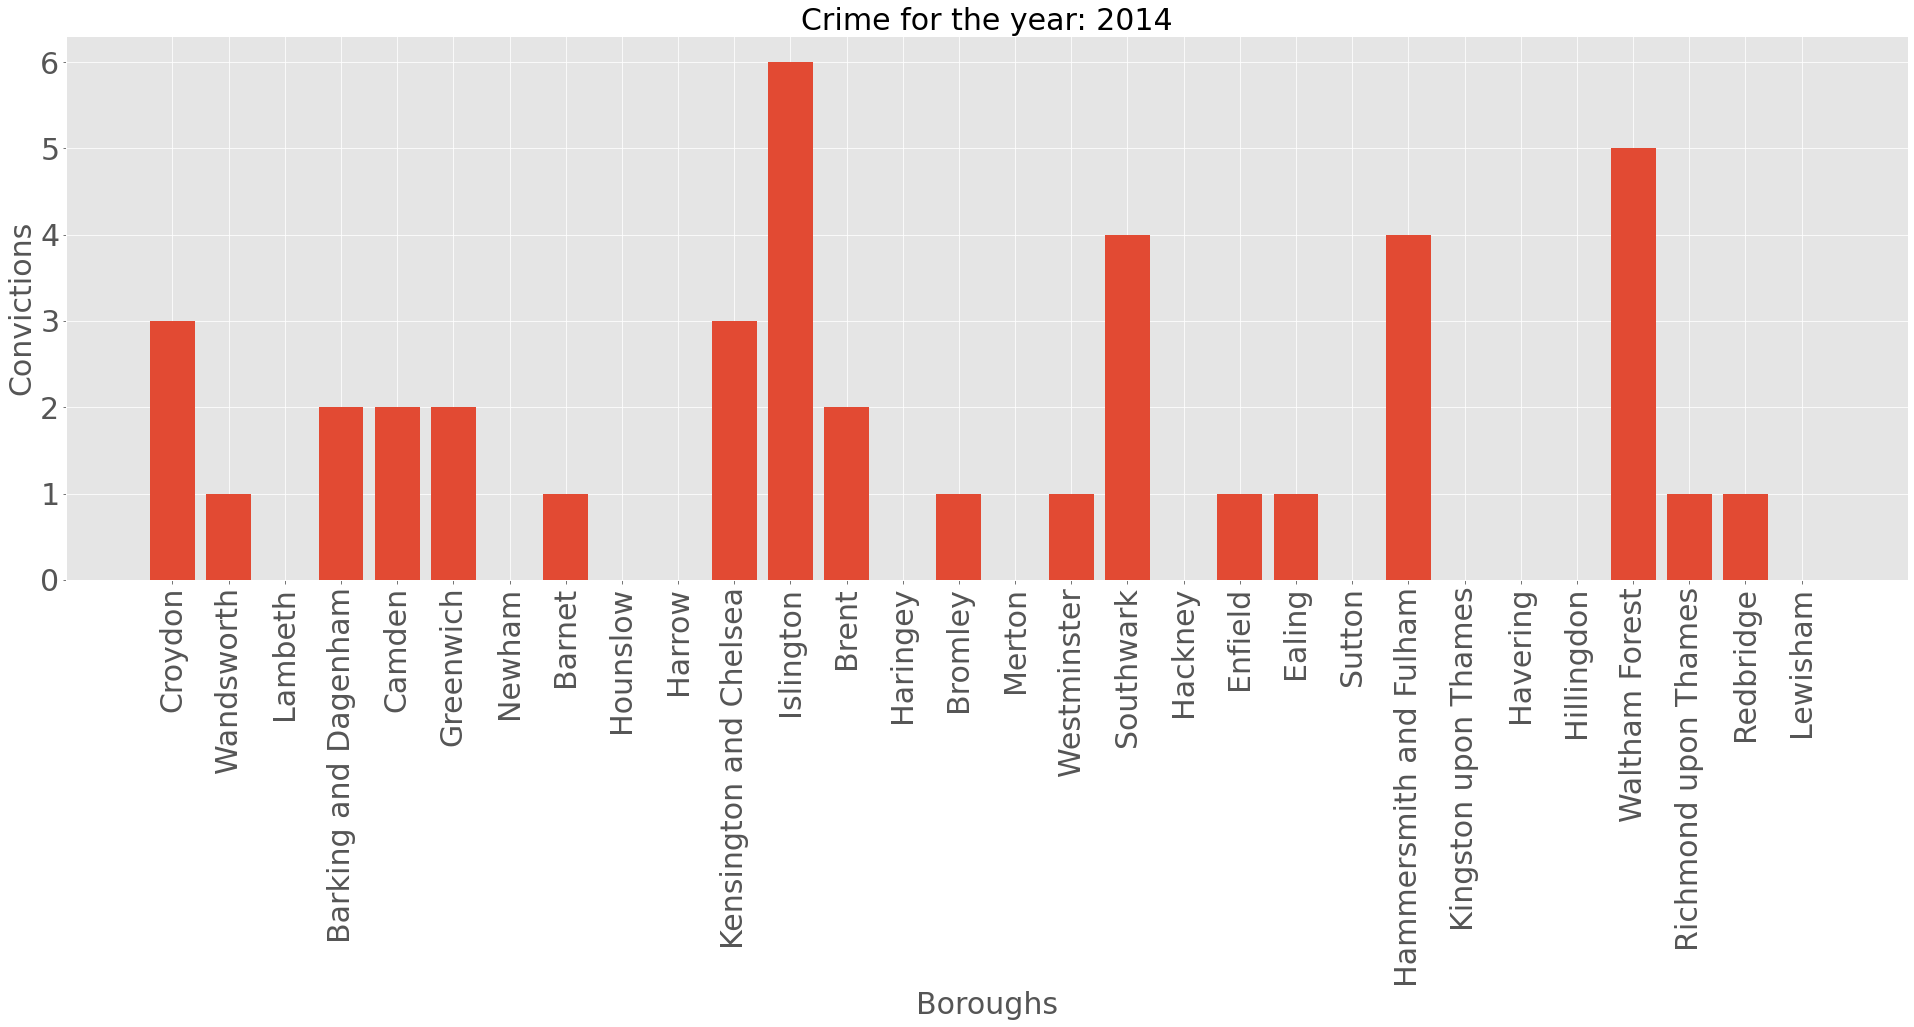

In [ ]:
describe_year('2014')